# Collaboration and Competition



In this notebook we go about training the agent with the MADDPG algorithm. To this end we import the required packages and load the enviromenent. Make sure that the Tennis app is in the local directory.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from training import train
import matplotlib.pyplot as plt
import torch
from model import Actor
from IPython.display import Image


In [2]:
env = UnityEnvironment(file_name="Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


# Training the Model



DDPG is an extension of the DQN algorithm to continuous action spaces. When the environment contains a continuous action space we are unable to choose the maximum activon value for a given state by direct comparison as one might do in a discrete space. Therefore another set of neural networks is introduced to act as a action maximizer. We use this action to make take our steps in the enviroment and update the neural networks that give us our action values. We call the action value networks critics and the action networks actors. The critic network is updated by using a collected experience to find a difference between the Q value we get in one state and the value of that Q value that we would predict from another state. We take the gradient of this loss and update our network based on gradient descent. In order to avoid instability two different networks are used a target network and a local network. This is also done for the actor network. The local actor network is updated by sending the outputed action in combination with the state from an experience to the critc network and then using gradient ascent. We use gradient ascent because this is suppsoed to be an action maximizer.

D4PG is almost the same but uses a distributional perspective for the Q value neural network. This was introduced by Barth-Maron et al (https://openreview.net/pdf?id=SyZipzbCb) where they found categorical distributions to work very well compared to standard DDPG. To calculate the loss in the case we take the cross entropy of the target and local distributions.

Another modification available in the code here is n_step returns. Rather than training every step this trains every n steps. This can be seen as sortof half way towards monte carlo estimates. We also provide the oportunity to train the agent multiple times (in addition to the batch size) during this time.

Noise can also be turned on to enhance exploration. This should help the agent adequately explore the space especially early in training. We also use a explore_factor that controls how much noise is added to the weights of the actor network.

Rather than Relu activation functions our neural networks are built using SELU activation functions which should normalize our parameters in each layer to mean zero and standard deviation 1 as they train.

MADDPG is an extension of DDPG for multiple cooperating agents. For each agent, MADDPG uses a critic which can see both agents observations and actions and an actor which can only see the local observations. MAD4PG uses D4PG instead of DDPG for the individual agents. This did not work as well as I hoped, maybe additional hyperparameter tunning is needed for the MAD4PG.

below you can adjust the hyperparameters of the training


In [3]:
param={    
    'n_step':1, #how many time steps we take before we make our TD estimate
    'n_episodes':10000, #maximum episodes to run (code will stop if average score is above 30 before this number)
    'noise':True,# controls whether Ornstein–Uhlenbeck noise is added to each parameter of the actor
    'print':False,
    'agentparam':
    {
        'device':'cpu',
        'action_size' : 2, 
        'state_size' : 24,
        'seed' : 10,
        'update_times':1, #how many times we learn at every step

        'ddpgtype':'singleval', #distribution type: 'catdist' for categorical distribution (MAD4PG) or "singleval" for classic MADDPG
        'atoms' : 51, #atoms for D4PG


        'catparam':
        {
            'vmin' : 0, #minimum q category
            'vmax' : 1 #maximum q category
        },

        'gamma' : 0.999, #discount factor : how much future rewards are discounted
        'lr_actor' : 1e-4, #actor network learning rate
        'lr_critic' : 1e-3, #critic network learning rate
        'l2weights' : 0, #weight decay in adam optimizer, equivalent to l2 regularization
        'tau' : 1e-3, #controls how quickly the target networks are updated
        'explore_factor' :0.1, #controls how much noise is added to each action parameter
        'batch_size' : 512,#how many experiences sampled in each batch

        'replay_param' :
        {
            'buffer_size': int(1e6), #max length of buffer
        },
    
        'OUparam':
        {
            'sigma': 0.5, #width of noise distribution
            'mu':0, #Noise will be centered around mu
            'theta':0.15 #how large a step we take towards the mean
        },
        
        'criticparam':
        {
            'layer_units':[300,150] #List items create layers with n number of neurons, add item for additional layer
        }, 
        
        'actorparam':
        {
            'layer_units':[200,100]  #List items create layers with n number of neurons, add item for additional layer
        }
        
    }
      }

In [4]:
scores,avgscores=train(env,param)

Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.00
Episode 300	Average Score: 0.01
Episode 400	Average Score: 0.01
Episode 500	Average Score: 0.01
Episode 600	Average Score: 0.01
Episode 700	Average Score: 0.01
Episode 800	Average Score: 0.04
Episode 900	Average Score: 0.08
Episode 1000	Average Score: 0.08
Episode 1100	Average Score: 0.26
Episode 1200	Average Score: 0.27
Episode 1300	Average Score: 0.42
Episode 1400	Average Score: 2.48
Episode 1500	Average Score: 1.95
Agent took 0 hours and 57 minutes to solve enviroment in 1311 episodes


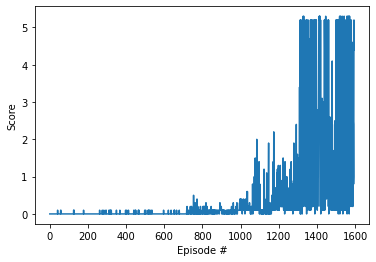

In [9]:
fig = plt.figure()
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

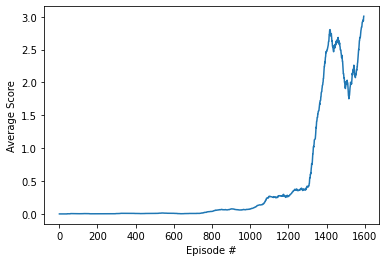

In [7]:
fig = plt.figure()
plt.plot(np.arange(1, len(avgscores)+1), avgscores)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()

To investigate the actor and critic losses of the individual agents run the cell below to open tensorboard

In [ ]:
!tensorboard --logdir=runs

# Testing the agent

Here we load and test our agent

In [12]:
TrainedActor0=Actor(24,2,10,param['agentparam']['actorparam'])
TrainedActor0.load_state_dict(torch.load('checkpoint_actor0.pth'))
TrainedActor0.eval()

Actor(
  (hlayers): Sequential(
    (0): Linear(in_features=24, out_features=200, bias=True)
    (1): SELU()
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3): SELU()
  )
  (out): Linear(in_features=100, out_features=2, bias=True)
  (outlayer): Sequential(
    (0): Linear(in_features=100, out_features=2, bias=True)
    (1): Tanh()
  )
)

In [13]:
TrainedActor1=Actor(24,2,10,param['agentparam']['actorparam'])
TrainedActor1.load_state_dict(torch.load('checkpoint_actor1.pth'))
TrainedActor1.eval()

Actor(
  (hlayers): Sequential(
    (0): Linear(in_features=24, out_features=200, bias=True)
    (1): SELU()
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3): SELU()
  )
  (out): Linear(in_features=100, out_features=2, bias=True)
  (outlayer): Sequential(
    (0): Linear(in_features=100, out_features=2, bias=True)
    (1): Tanh()
  )
)

In [14]:
actors=[TrainedActor0,TrainedActor1]
actions=np.zeros((2,2))
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [15]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
num_agents=20                                          # change to appropriate number for your enviroment
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    states=torch.from_numpy(states).float()
    for i,state in enumerate(states):
        actions[i,:] = actors[i](state).detach().numpy()    # select an action (for each agent)
        actions[i,:] = np.clip(actions[i,:], -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += np.max(env_info.rewards)                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))


Total score (averaged over agents) this episode: 5.200000077486038


In [ ]:
Image(url='trainedTennis.gif')  


This is a gif of our trained agent

In [ ]:
env.close()

# Future Improvements

In the future we could try a few things. I think implementing starting with a greater noise and exploration and then introducing a decay hyperparameter would help us find the right model parameters quickly and then converge well once we have reached found the first good area to search for neural network weights. In MADDPG it took us till around episode 1800 to find this area and this could help us find it sooner and solve our system with less training time. 

Hyperparameters could also be searched with a grid search, given enough training time to find the hyperparameters that could achieve a certain score with the least amount of training.

Prioritized replay might also help with our sittuation at the beggining by selecting the most important experiences. It seemed once the model started getting enough of the right experiences it rapidly learned and so prioritized replay in particular has good potential too improve our model